In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sb
%matplotlib inline

In [2]:
cols=pd.read_csv(os.path.join("Video+Game+Sales","vgchartz-2024.csv"),nrows=0).columns
cols=cols.drop("img") # we don't need that
dtypes={"console":"category","genre":"category","critic_score":"float32","total_sales":"float32",\
       "na_sales":"float32","jp_sales":"float32","pal_sales":"float32","other_sales":"float32"}
videogames_sales=pd.read_csv(os.path.join("Video+Game+Sales","vgchartz-2024.csv"),usecols=cols,\
       parse_dates=["release_date","last_update"] ,dtype=dtypes ,\
         na_values=["''"],keep_default_na=True                   )
columns_renamed={"na_sales":"usa_sales","jp_sales":"japan_sales",\
                 "pal_sales":"euro_africa_sales"}
videogames_sales.rename(columns=columns_renamed,inplace=True)
videogames_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              64016 non-null  object        
 1   console            64016 non-null  category      
 2   genre              64016 non-null  category      
 3   publisher          64016 non-null  object        
 4   developer          63999 non-null  object        
 5   critic_score       6678 non-null   float32       
 6   total_sales        18922 non-null  float32       
 7   usa_sales          12637 non-null  float32       
 8   japan_sales        6726 non-null   float32       
 9   euro_africa_sales  12824 non-null  float32       
 10  other_sales        15128 non-null  float32       
 11  release_date       56965 non-null  datetime64[ns]
 12  last_update        17879 non-null  datetime64[ns]
dtypes: category(2), datetime64[ns](2), float32(6), object(3)
memo

In [3]:
videogames_sales.head()

,title,console,genre,publisher,developer,critic_score,total_sales,usa_sales,japan_sales,euro_africa_sales,other_sales,release_date,last_update
0,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.320000,6.37,0.99,9.85,3.12,2013-09-17,NaT
1,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.389999,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.150000,8.41,0.47,5.49,1.78,2002-10-28,NaT
3,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.860000,9.06,0.06,5.33,1.42,2013-09-17,NaT
4,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.090000,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [4]:
# preparing the data
videogames_sales["title"].str.contains("^\s+").any()


False

In [5]:
videogames_sales["developer"].fillna("Unknown",inplace=True)

In [6]:
videogames_sales["publisher"].fillna("Unknown",inplace=True)

In [7]:
# due to having a very brocken file with lots of 
#missing info in many columns i will use it to 
#analyse different parts like japan ,usa etc
total_sales_df=videogames_sales[videogames_sales["total_sales"].notna()]
total_sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18922 entries, 0 to 18921
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   title              18922 non-null  object        
 1   console            18922 non-null  category      
 2   genre              18922 non-null  category      
 3   publisher          18922 non-null  object        
 4   developer          18922 non-null  object        
 5   critic_score       4126 non-null   float32       
 6   total_sales        18922 non-null  float32       
 7   usa_sales          12637 non-null  float32       
 8   japan_sales        6726 non-null   float32       
 9   euro_africa_sales  12824 non-null  float32       
 10  other_sales        15128 non-null  float32       
 11  release_date       18832 non-null  datetime64[ns]
 12  last_update        4019 non-null   datetime64[ns]
dtypes: category(2), datetime64[ns](2), float32(6), object(3)
memory us

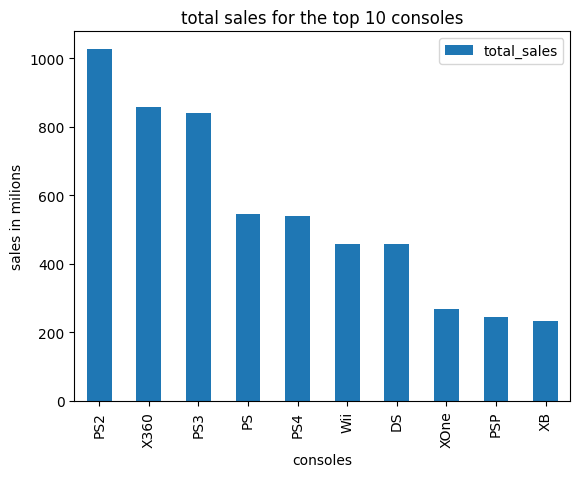

In [8]:
consoles=total_sales_df.groupby("console")
top_10_consoles=consoles["total_sales"].sum().sort_values(ascending=False)[:10]
top_10_consoles.plot(kind="bar")
plt.ylabel("sales in milions")
plt.xlabel("consoles")
plt.title("total sales for the top 10 consoles")
plt.legend()

Text(0.5, 1.0, 'games of each genre for top 10 consoles')

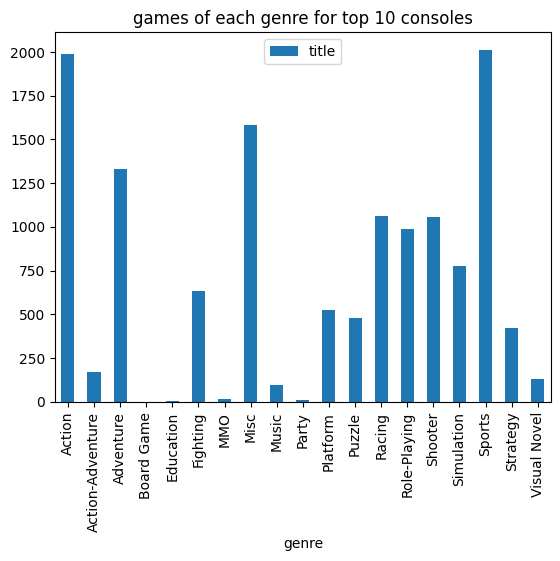

In [9]:
consoles.filter(lambda x: x.name in top_10_consoles.index)\
.groupby(["genre"],observed=True).count().plot(kind="bar",y="title")
plt.title("games of each genre for top 10 consoles")

Text(0.5, 1.0, 'produced games for each console')

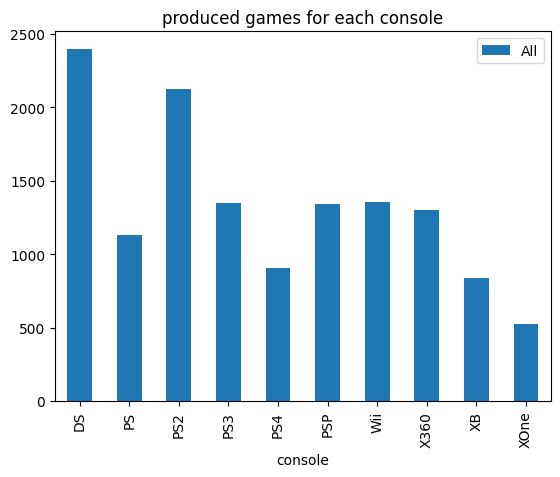

In [10]:
games_genres=consoles.filter(lambda x:x.name in top_10_consoles.index)[["genre","console","title"]]\
.pivot_table(index=["console"],columns=["genre"],values="title",aggfunc="count"\
,observed=True,\
            fill_value=0,margins=True)
games_genres.drop(labels="All",axis=0).plot(kind="bar",y="All")
plt.title("produced games for each console")

Text(0.5, 1.0, 'most produced genre for each console')

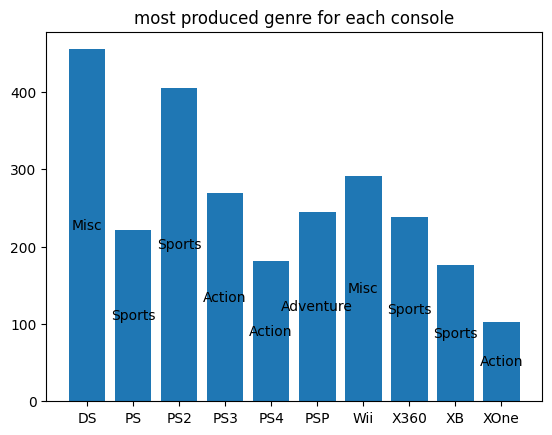

In [11]:
def get_top_genre(console):
    """ get the genre with most games
    for every console"""
    fields=["genre","count"]
    genre,count=sorted(console.items(),key=lambda genre:genre[1],reverse=True)[0]
    return pd.Series(dict(zip(fields,[genre,count])))
top_genres=games_genres.drop("All",axis=0).drop("All",axis=1)\
.apply(lambda x:get_top_genre(x),axis=1)
fig,ax=plt.subplots()
bar=ax.bar(top_genres.index,top_genres["count"].values)
ax.bar_label(bar,labels=top_genres["genre"].values,label_type="center")
ax.set_title("most produced genre for each console")


Text(0.5, 1.0, 'total games and sales for top 10 consoles')

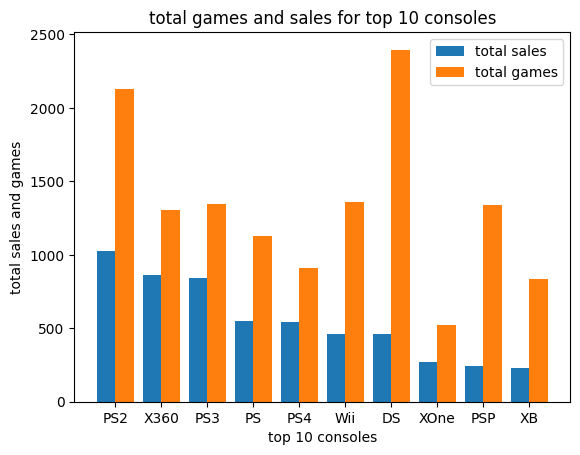

In [12]:
# a graph for the total sales and total games for each console of top 10
xs=np.arange(len(top_10_consoles.index))
consoles_sales=[top_10_consoles[i] for i in xs]
consoles_games=[games_genres["All"][console] for console in top_10_consoles.index]
plt.bar(xs-0.2,consoles_sales,0.4,label="total sales")
plt.bar(xs+0.2,consoles_games,0.4,label="total games")
plt.legend()
plt.xticks(xs,top_10_consoles.index)
plt.xlabel("top 10 consoles")
plt.ylabel("total sales and games")
plt.title("total games and sales for top 10 consoles")

Text(0.5, 1.0, 'games per year')

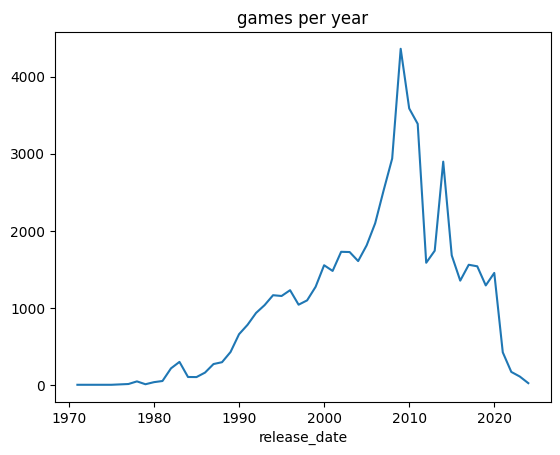

In [13]:
release_years=videogames_sales[videogames_sales["release_date"].notna()].reset_index()
release_years.groupby(release_years["release_date"].dt.year).count()["title"].plot()
plt.title("games per year")

Text(0.5, 0, 'genres')

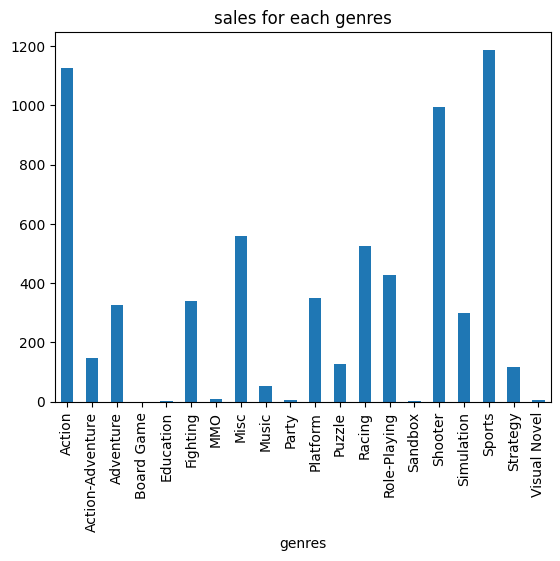

In [14]:
total_sales_df.groupby("genre")["total_sales"].sum().plot(kind="bar")
plt.title("sales for each genres")
plt.xlabel("genres")

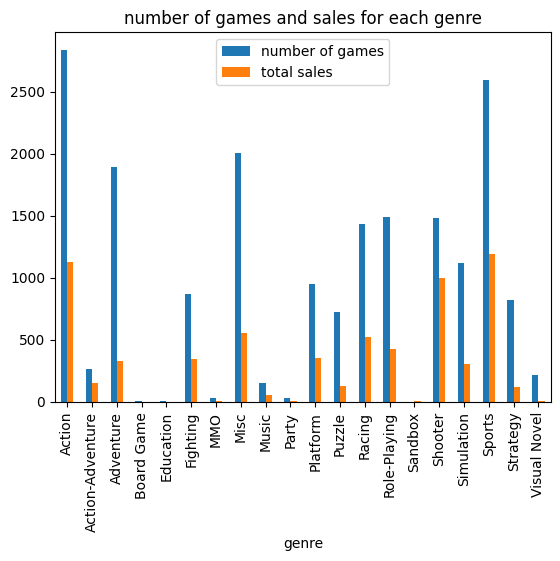

In [15]:
total_sales_df.groupby("genre")[["title","total_sales"]]\
.aggregate({"title":"count","total_sales":"sum"}).plot(y=["title","total_sales"],kind="bar")
plt.title("number of games and sales for each genre")
plt.legend(["number of games","total sales"])

In [16]:
#getting games with sales in all areas
areas_sales=total_sales_df[(total_sales_df["usa_sales"].notna()) &
(total_sales_df["japan_sales"].notna()) &
(total_sales_df["euro_africa_sales"].notna()) &
(total_sales_df["other_sales"].notna())].reset_index(drop=True)


Text(0.5, 1.0, 'console sales in usa')

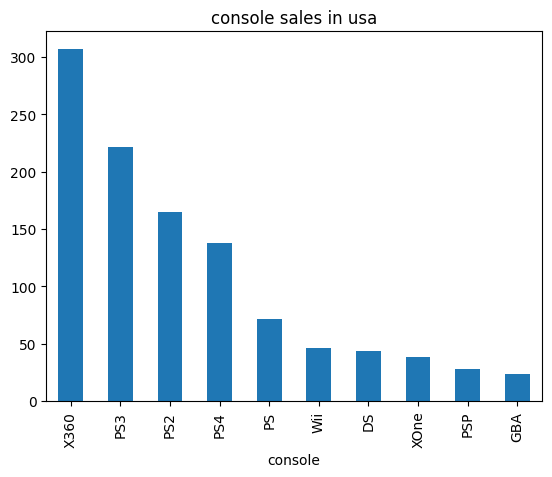

In [17]:
areas_sales.pivot_table(index="console",\
    values=["usa_sales","euro_africa_sales","japan_sales","other_sales"],aggfunc="sum")\
["usa_sales"].sort_values(ascending=False)[:10].plot(kind="bar")
plt.title("console sales in usa")

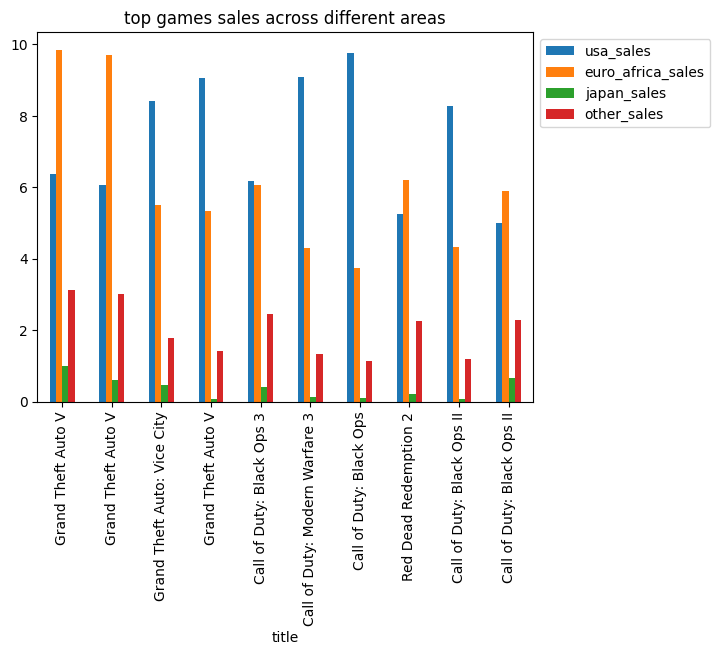

In [18]:
areas_sales.sort_values(by="total_sales",ascending=False)[:10]\
.plot(x="title",y=["usa_sales","euro_africa_sales","japan_sales","other_sales"],kind="bar")
plt.title("top games sales across different areas")
plt.legend(loc="upper left",bbox_to_anchor=(1,1))

<Axes: xlabel='genre'>

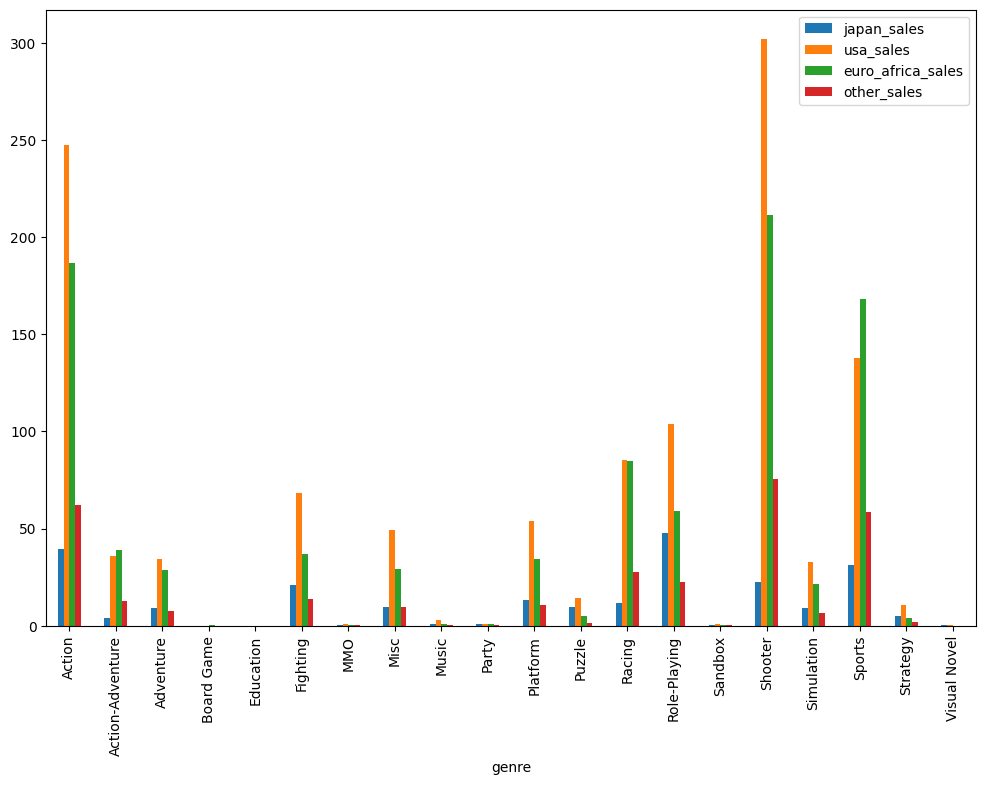

In [19]:
areas_sales.groupby("genre")[["japan_sales","usa_sales","euro_africa_sales","other_sales"]]\
.sum().plot(kind="bar",figsize=(12,8))

Text(0.5, 1.0, 'top console for each area')

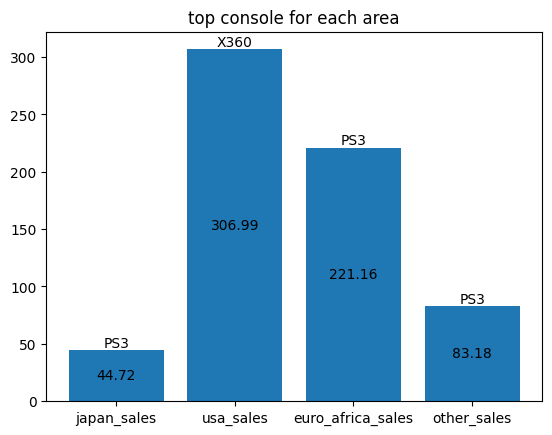

In [21]:
areas_consoles=areas_sales.groupby("console")\
[["japan_sales","usa_sales","euro_africa_sales","other_sales"]].sum().T\
.apply(lambda area:get_top_genre(area),axis=1)
areas_consoles.rename(columns={"genre":"console"},inplace=True)
fig,ax=plt.subplots()
bar=ax.bar(areas_consoles.index,areas_consoles["count"].values)
ax.bar_label(bar,labels=areas_consoles["console"],label_type="edge")
ax.bar_label(ax.containers[0],label_type="center")
ax.set_title("top console for each area")



